# VO2max Prediction Using Treadmill Maximal Exercise Tests and Machine Learning Techniques

In [87]:
# import packages
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import signal
from collections import Counter
from sklearn.utils import indexable
from sklearn.utils import resample
from sklearn.utils.validation import _num_samples
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from itertools import chain
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, MultiTaskLassoCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from math import ceil, floor
from scipy.signal import welch
from scipy.stats import linregress, shapiro

In [88]:
# load subject dataset
subject_data = pd.read_csv('physionet.org/files/treadmill-exercise-cardioresp/1.0.1/subject-info.csv')

# basic information
display(subject_data.head())
print("Initial Dataset Info:")
print(subject_data.info())
print(subject_data.describe())

,Age,Weight,Height,Humidity,Temperature,Sex,ID,ID_test
0,10.8,48.8,163.0,39.0,20.7,1,543,543_1
1,11.8,41.0,150.0,41.0,22.3,1,11,11_1
2,12.2,46.0,160.0,37.0,21.5,0,829,829_1
3,13.2,71.0,190.0,49.0,23.8,1,284,284_1
4,13.7,53.8,169.7,40.0,25.3,0,341,341_1


Initial Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          992 non-null    float64
 1   Weight       992 non-null    float64
 2   Height       992 non-null    float64
 3   Humidity     962 non-null    float64
 4   Temperature  962 non-null    float64
 5   Sex          992 non-null    int64  
 6   ID           992 non-null    int64  
 7   ID_test      992 non-null    object 
dtypes: float64(5), int64(2), object(1)
memory usage: 62.1+ KB
None
              Age      Weight      Height    Humidity  Temperature  \
count  992.000000  992.000000  992.000000  962.000000   962.000000   
mean    28.979133   73.383367  174.913508   48.211435    22.818565   
std     10.076653   12.005361    7.950027    8.560991     2.784066   
min     10.800000   41.000000  150.000000   23.700000    15.000000   
25%     21.100000   66.000000  170.0

In [89]:
# load measurement dataset
measurement_data = pd.read_csv('physionet.org/files/treadmill-exercise-cardioresp/1.0.1/test_measure.csv')

# basic information
print("Measurement Data Overview:")
display(measurement_data.head())
print("Measurement Dataset Info:")
print(measurement_data.info())

Measurement Data Overview:


,time,Speed,HR,VO2,VCO2,RR,VE,ID_test,ID
0,0,5.0,63.0,478.0,360.0,27,13.3,2_1,2
1,2,5.0,75.0,401.0,295.0,23,10.3,2_1,2
2,4,5.0,82.0,449.0,319.0,29,12.2,2_1,2
3,7,5.0,87.0,461.0,340.0,28,12.8,2_1,2
4,9,5.0,92.0,574.0,417.0,28,14.6,2_1,2


Measurement Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575087 entries, 0 to 575086
Data columns (total 9 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   time     575087 non-null  int64  
 1   Speed    575087 non-null  float64
 2   HR       574106 non-null  float64
 3   VO2      570216 non-null  float64
 4   VCO2     570216 non-null  float64
 5   RR       575087 non-null  int64  
 6   VE       575087 non-null  float64
 7   ID_test  575087 non-null  object 
 8   ID       575087 non-null  int64  
dtypes: float64(5), int64(3), object(1)
memory usage: 39.5+ MB
None


## Feature Selection

The feature selection process is based on the Paper: Heart Rate Variability Based Estimation of Maximal Oxygen
Uptake in Athletes Using Supervised Regression Models .

### Data Cleaning and Pre-processing

In [90]:
# check if there are missing values
print("Missing Values per Column:")
print(measurement_data.isnull().sum())

Missing Values per Column:
time          0
Speed         0
HR          981
VO2        4871
VCO2       4871
RR            0
VE            0
ID_test       0
ID            0
dtype: int64


In [91]:
def pipeline_data_cleaning(data):
    """
    Preprocess the data by removing missing values, outliers, and ensuring HR and VO2 are in-phase.
    """
    
    # remove rows with missing target variable (HR, VO2)
    measurement_data_cleaned = data.dropna(subset=['HR', 'VO2'])

    # Check how many rows are removed
    print(f'Rows removed due to missing HR or VO2: {len(data) - len(measurement_data_cleaned)}')

    # Remove RR intervals outside the range of 5-50 breaths per minute (outliers)
    measurement_data_cleaned['RR'] = np.where((measurement_data_cleaned['RR'] < 5) | (measurement_data_cleaned['RR'] > 50), np.nan, measurement_data_cleaned['RR'])

    # linear interpolation to fill missing values
    measurement_data_cleaned['RR'] = measurement_data_cleaned['RR'].interpolate(method='linear')

    # Check for NaN values after interpolation
    print("Remaining Missing Values after Interpolation:")
    print(measurement_data_cleaned.isnull().sum())

    # remove data points where HR and VO2 are out of ohase
    delta_hr = np.diff(measurement_data_cleaned['HR'])
    delta_vo2max = np.diff(measurement_data_cleaned['VO2'])

    # Ensure indices match before masking
    measurement_data_cleaned = measurement_data_cleaned.iloc[:-1]  # Drop the last row
    in_phase_mask = (delta_hr * delta_vo2max) > 0  # Create a mask for in-phase points
    measurement_data_cleaned =  measurement_data_cleaned[in_phase_mask]

    #  remove where consecutive HR differs more by than 30 bpm
    measurement_data_cleaned['HR_diff'] = measurement_data_cleaned['HR'].diff().abs()
    measurement_data_cleaned = measurement_data_cleaned[measurement_data_cleaned['HR_diff'] <= 30]

    # remove objects with less than 5 minutes of data
    measurement_data_cleaned['time'] = measurement_data_cleaned['time'].astype(float)  # make it numeirc
    measurement_data_cleaned = measurement_data_cleaned[measurement_data_cleaned['time'] >= 300]

    # check dataset
    print(f'Dataset size after cleaning: {measurement_data_cleaned.shape}')

    # split data into exercise and recovery phases
    exercise_data = measurement_data_cleaned[measurement_data_cleaned['Speed'] >= 5]  # Exercise phase
    recovery_data = measurement_data_cleaned[measurement_data_cleaned['Speed'] < 5]  # Recovery phase
    
    return exercise_data, recovery_data

exercise_data, recovery_data = pipeline_data_cleaning(measurement_data)
# shapes of dataframes
print(f'Exercise data size: {exercise_data.shape}')
print(f'Recovery data size: {recovery_data.shape}')

Rows removed due to missing HR or VO2: 5840
Remaining Missing Values after Interpolation:
time       0
Speed      0
HR         0
VO2        0
VCO2       0
RR         0
VE         0
ID_test    0
ID         0
dtype: int64
Dataset size after cleaning: (100039, 10)
Exercise data size: (85872, 10)
Recovery data size: (14167, 10)


/var/folders/bd/3yf697f17xx34gzbkjr3wz9r0000gn/T/ipykernel_49280/3189033610.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  measurement_data_cleaned['RR'] = np.where((measurement_data_cleaned['RR'] < 5) | (measurement_data_cleaned['RR'] > 50), np.nan, measurement_data_cleaned['RR'])
/var/folders/bd/3yf697f17xx34gzbkjr3wz9r0000gn/T/ipykernel_49280/3189033610.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  measurement_data_cleaned['RR'] = measurement_data_cleaned['RR'].interpolate(method='linear')


In [92]:
# Remove all data from test IDs with missing HR or VO2
#difference = pd.merge(merged_data, measurement_data_cleaned, how='outer', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)
#exclude_ids = difference['ID_test'].unique()
#measurement_data_cleaned = measurement_data_cleaned[~measurement_data_cleaned['ID_test'].isin(exclude_ids)]

## Feature Extraction

In [93]:
def poincare_plot(data):
        
    # Sample RR intervals
    rr_intervals = data['RR'].values
    # Calculate consecutive differences for Poincaré plot
    rr_diff1 = rr_intervals[:-1]  # RR interval at time t
    rr_diff2 = rr_intervals[1:]  # RR interval at time t+1

    # Calculate mean of RR intervals
    rr_mean = np.mean(rr_intervals)

    # Calculate SD1 and SD2
    sd1 = np.sqrt(0.5) * np.std(rr_diff2 - rr_diff1)
    sd2 = np.sqrt(2 * np.std(rr_diff1)**2 - sd1**2)

    # Line of identity
    identity_line = np.linspace(min(rr_intervals), max(rr_intervals), 100)

    # Create Poincaré plot
    plt.figure(figsize=(8, 8))
    plt.scatter(rr_diff1, rr_diff2, alpha=0.6, label="RR intervals")
    plt.plot(identity_line, identity_line, color="red", linestyle="--", label="Line of Identity")
    plt.xlim(min(rr_intervals), max(rr_intervals)+20)
    plt.ylim(min(rr_intervals), max(rr_intervals)+20)

    # SD1 and SD2 ellipse visualization
    mean_rr = [np.mean(rr_diff1), np.mean(rr_diff2)]
    ellipse_angle = 45
    ellipse_sd1 = plt.Circle(mean_rr, sd1, color="blue", fill=False, label="SD1")
    ellipse_sd2 = plt.Circle(mean_rr, sd2, color="green", fill=False, label="SD2")
    plt.gca().add_patch(ellipse_sd1)
    plt.gca().add_patch(ellipse_sd2)

    # Formatting
    plt.title("Poincaré Plot")
    plt.xlabel("RR Interval (n)")
    plt.ylabel("RR Interval (n+1)")
    plt.legend()
    plt.grid(alpha=0.4)
    plt.axis("equal")
    plt.show()

    # Print SD1 and SD2
    print(f"SD1: {sd1:.2f} ms")
    print(f"SD2: {sd2:.2f} ms")



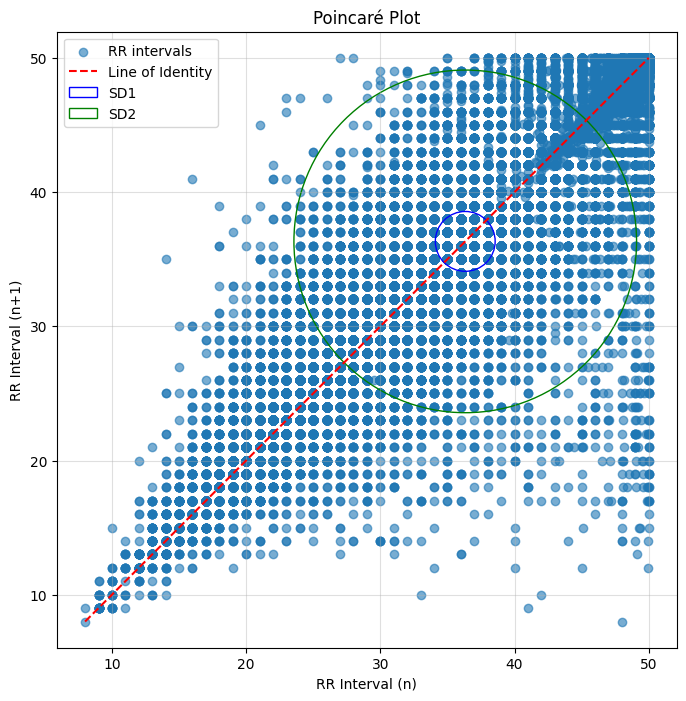

SD1: 2.23 ms
SD2: 12.77 ms


In [94]:
poincare_plot(exercise_data)

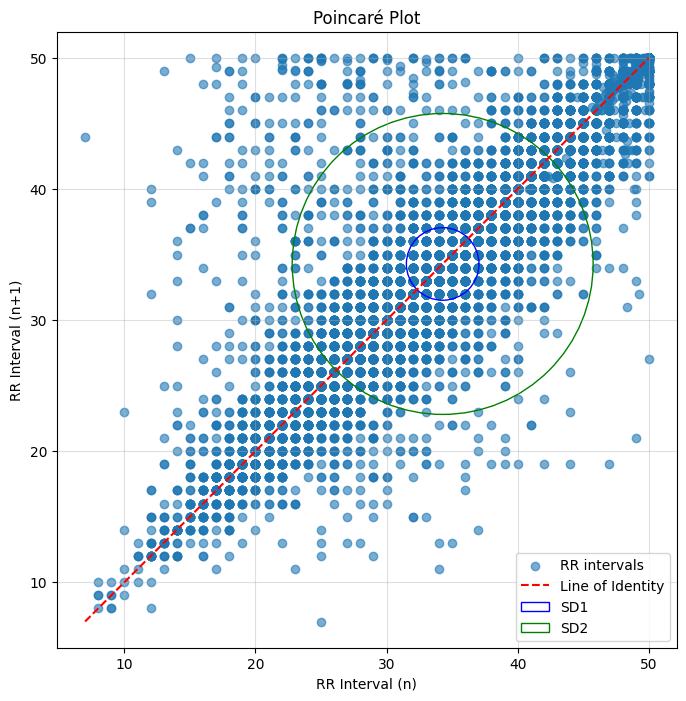

SD1: 2.77 ms
SD2: 11.48 ms


In [95]:
poincare_plot(recovery_data)

In [96]:

# Function to calculate slopes over time for a feature

def calculate_slopes(df, feature):
    """
    Calculate the slope of a feature over time using linear regression.

    Parameters:
    df (pd.DataFrame): DataFrame containing the 'time' and feature columns.
    feature (str): The feature column for which the slope is calculated.

    Returns:
    float: Slope of the feature over time. NaN if the input DataFrame is empty.
    """
    if len(df) == 0:  # Handle empty DataFrame
        return np.nan
    else:
        # Use linear regression to calculate the slope
        slope = linregress(df['time'], df[feature]).slope
        return slope
    



In [97]:
 # Function to compute HR & HRV features for a given data segment

def compute_hr_features(segment: pd.DataFrame) -> dict:
    """
    Calculate heart rate variability (HRV) features and additional metrics from a data segment.

    Parameters:
    segment (pd.DataFrame): A DataFrame containing the segment data.

    Returns:
    dict: A dictionary of computed features.
    """

    hr = segment['HR'].values
    time = segment['time'].values
    rr_intervals = segment['RR'].values 

    # Time-Domain-Features
    rmssd = np.sqrt(np.mean(np.diff(rr_intervals) ** 2))  # RMSSD: Root Mean Square of Successive Differences
    pnn20 = np.mean(np.abs(np.diff(rr_intervals)) > 0.5) * 100  # % of differences > 20 ms
    pnn50 = np.mean(np.abs(np.diff(rr_intervals)) > 1.25) * 100  # % of differences > 50 ms
    nni20 = np.sum(np.abs(np.diff(rr_intervals)) > 0.5)  # Count of differences > 20 ms
    nni50 = np.sum(np.abs(np.diff(rr_intervals)) > 1.25)  # Count of differences > 50 ms
    nni_range = np.max(rr_intervals) - np.min(rr_intervals)  # Range of RR intervals
    
    # Frequency-Domain-Features
    fs = 4  # Sampling frequency in Hz (adjust based on your data)
    f, pxx = welch(rr_intervals, fs, nperseg=len(rr_intervals))  # Welch's power spectral density
    vlf_power = np.trapz(pxx[(f >= 0.003) & (f < 0.04)], f[(f >= 0.003) & (f < 0.04)])  # VLF band
    lf_power = np.trapz(pxx[(f >= 0.04) & (f < 0.15)], f[(f >= 0.04) & (f < 0.15)])  # LF band
    hf_power = np.trapz(pxx[(f >= 0.15) & (f < 0.4)], f[(f >= 0.15) & (f < 0.4)])  # HF band
    lf_nu_power = lf_power / (vlf_power + lf_power + hf_power)  # LF normalized power

    # Nonlinear Features (Poincare Plot, DFA)
    sd1 = np.sqrt(0.5) * np.std(rr_intervals[1:] - rr_intervals[:-1])  # Short-term variability
    sd2 = np.sqrt(2 * np.std(rr_intervals[:-1]) ** 2 - sd1 ** 2)  # Long-term variability
    dfa_a1 = np.std(rr_intervals[:len(rr_intervals)//2]) / np.std(rr_intervals)  # Placeholder for DFA Alpha-1
    
    # Slope-Based Features
    slope_nni = np.polyfit(time, rr_intervals, 1)[0]  # Slope of NN intervals over time

    # Additional Features
    max_hr = max(hr)  # Max HR in the segment
    min_hr = min(hr)  # Min HR in the segment
    vo2_max = segment['VO2'].max()  # Max VO2 in the segment
    
    # Slopes for Poincare Plot Features
    # slope_sd1 = np.polyfit(time, [sd1] * len(time), 1)[0]
    # slope_sd2 = np.polyfit(time, [sd2] * len(time), 1)[0]

    # Time-based features
    max_speed = segment['Speed'].max()
    slope_sp25 = calculate_slopes(segment[segment['Speed'] <= max_speed * 0.25], 'HR')
    slope_sp50 = calculate_slopes(segment[(segment['Speed'] <= max_speed * 0.5) & (segment['Speed'] > max_speed * 0.25)], 'HR')
    slope_sp75 = calculate_slopes(segment[(segment['Speed'] <= max_speed * 0.75) & (segment['Speed'] > max_speed * 0.5)], 'HR')
    slope_sp100 = calculate_slopes(segment[(segment['Speed'] > max_speed * 0.75)], 'HR')
    rt25 = segment.loc[segment['time'] <= segment['time'].max() * 0.25, 'HR'].corr(segment['time'])
    rt50 = segment.loc[(segment['time'] >= segment['time'].max() * 0.25) & (segment['time'] < segment['time'].max() * 0.5), 'HR'].corr(segment['time'])
    rt75 = segment.loc[(segment['time'] >= segment['time'].max() * 0.5) & (segment['time'] < segment['time'].max() * 0.75), 'HR'].corr(segment['time'])
    rsp75 = segment.loc[segment['Speed'] <= max_speed * 0.75, 'HR'].corr(segment['Speed'])
    rsp25 = segment.loc[segment['Speed'] <= max_speed * 0.25, 'HR'].corr(segment['Speed'])
    time_sp25 = segment[segment['Speed'] >= max_speed * 0.25]['time'].min()
    time_hr25 = segment[segment['HR'] >= max_hr * 0.25]['time'].min()
    time_hr50 = segment[segment['HR'] >= max_hr * 0.5]['time'].min()
    time_hr75 = segment[segment['HR'] >= max_hr * 0.75]['time'].min()
    duration_hr60 = len(segment[(segment['HR'] >= max_hr * 0.5) & (segment['HR'] < max_hr * 0.6)]) * (segment['time'].diff().mean())
    duration_hr70 = len(segment[(segment['HR'] >= max_hr * 0.6) & (segment['HR'] < max_hr * 0.7)]) * (segment['time'].diff().mean())
    duration_hr80 = len(segment[(segment['HR'] >= max_hr * 0.7) & (segment['HR'] < max_hr * 0.8)]) * (segment['time'].diff().mean())
    duration_hr90 = len(segment[(segment['HR'] >= max_hr * 0.8) & (segment['HR'] < max_hr * 0.9)]) * (segment['time'].diff().mean())
    duration_hr100 = len(segment[(segment['HR'] >= max_hr * 0.9) & (segment['HR'] <= max_hr)]) * (segment['time'].diff().mean())

    
    # Feature Dictionary
    Features = {'RMSSD': rmssd,
        'PNN20': pnn20,
        'PNN50': pnn50,
        'NNI20': nni20,
        'NNI50': nni50,
        'NNI_Range': nni_range,
        'VLF_Power': vlf_power,
        'LF_Power': lf_power,
        'HF_Power': hf_power,
        'LF_Nu_Power': lf_nu_power,
        'SD1': sd1,
        'SD2': sd2,
        'DFA_A1': dfa_a1,
        'Slope_NNI': slope_nni,
        'Slope_Speed25': slope_sp25,
        'Slope_Speed50': slope_sp50,
        'Slope_Speed75': slope_sp75,
        'Slope_Speed100': slope_sp100,
        'RT25': rt25,
        'RT50': rt50,
        'RT75': rt75,
        'RSP75': rsp75,
        'RSP25': rsp25,
        'Time_SP25': time_sp25,
        'Time_HR25': time_hr25,
        'Time_HR50': time_hr50,
        'Time_HR75': time_hr75,
        'DurationHR60': duration_hr60,
        'DurationHR70': duration_hr70,
        'DurationHR80': duration_hr80,
        'DurationHR90': duration_hr90,
        'DurationHR100': duration_hr100,
        'VO2max': segment['VO2'].max(),
    }
    
    return Features

In [98]:
# Function to calculate features for each segment
def calculate_features_per_segment(df, test_column):
    """
    Calculate features for each segment grouped by the specified column.

    Parameters:
    df (pd.DataFrame): The input data.
    test_column (str): The column to group by (e.g., test IDs).

    Returns:
    pd.DataFrame: DataFrame of computed features for each segment.
    """
    all_features = []  # List to store features for all segments

    for test_id, df_segment in df.groupby(test_column):  # Group by the test column
        features = compute_hr_features(df_segment)  # Compute features for the segment
        features[test_column] = test_id  # Add the test ID to the features
        all_features.append(features)  # Append the features

    return pd.DataFrame(all_features)  # Return all features as a DataFrame

In [99]:
# just for testing the feature calculat
# for test_id, df_segment in merged_data_cleaned.groupby('ID_test'):
#     #print(test_id)
#     if test_id == '3_1':
#         test_segment = merged_data_cleaned[merged_data_cleaned['ID_test'] == test_id]
#         break
# compute_hr_features(test_segment)

In [100]:
# Function to normalize numerical features in a DataFrame
def normalize_features(dataframe):
    """
    Normalize numerical features in a DataFrame using StandardScaler.

    Parameters:
    dataframe (pd.DataFrame): The input DataFrame.

    Returns:
    pd.DataFrame: A DataFrame with normalized numerical features.
    """
    # Identify numerical columns (excluding target variables or IDs)
    numerical_features = dataframe.select_dtypes(include=['float64', 'int64']).columns

    # Initialize StandardScaler (scales data to mean=0, std=1)
    scaler = StandardScaler()

    # Fit and transform numerical features
    normalized_data = scaler.fit_transform(dataframe[numerical_features])

    # Convert normalized data back to a DataFrame for readability
    normalized_df = pd.DataFrame(normalized_data, columns=numerical_features)

    # Copy the original DataFrame and replace numerical columns with normalized values
    normalized_features = dataframe.copy()
    normalized_features[numerical_features] = normalized_df

    return normalized_features



In [101]:
def pipeline_feature_extraction(data, subject_data):
    """
    Preprocess the data by removing missing values, outliers, and ensuring HR and VO2 are in-phase, 
    all well as merging with patient data normalizing the data.
    """
    
    additional_features = calculate_features_per_segment(data, 'ID_test')#ID_test_y')
    
    #new_features['ID_test'] = new_features['ID_test_y']
    merged_data = pd.merge(subject_data, additional_features, on='ID_test', how='inner')
    
    normalized_features = normalize_features(merged_data)
    
    return normalized_features

normalized_features_exercise = pipeline_feature_extraction(exercise_data, subject_data)
normalized_features_recovery = pipeline_feature_extraction(recovery_data, subject_data)

# shapes of dataframes
print(f'Exercise data size: {normalized_features_exercise.shape}')
print(f'Recovery data size: {normalized_features_recovery.shape}')

/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multip

Exercise data size: (981, 41)
Recovery data size: (317, 41)


/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multip

In [102]:
# Function to perform Shapiro-Wilk test for normality on each numerical feature
def shapiro_wilk_test(dataframe):
    """
    Perform the Shapiro-Wilk test for normality on all numerical features in the DataFrame.

    Parameters:
    dataframe (pd.DataFrame): The input DataFrame.

    Returns:
    tuple: A DataFrame with Shapiro-Wilk test results (statistic and p-value) 
           and another DataFrame identifying non-normally distributed features.
    """
    # Identify numerical columns (excluding target variables or IDs)
    numerical_features = dataframe.select_dtypes(include=['float64', 'int64']).columns

    # Dictionary to store Shapiro-Wilk test results
    shapiro_results = {}

    for column in numerical_features:
        # Perform Shapiro-Wilk test for the column
        stat, p = shapiro(dataframe[column])
        shapiro_results[column] = {'Statistic': stat, 'p-value': p}

    # Convert results dictionary to a DataFrame
    shapiro_results_df = pd.DataFrame(shapiro_results).T
    shapiro_results_df.columns = ['Shapiro Statistic', 'p-value']

    # Identify features that are not normally distributed (p-value <= 0.05)
    non_normal_features = shapiro_results_df[shapiro_results_df['p-value'] <= 0.05]

    return shapiro_results_df, non_normal_features



In [103]:
# Run Shapiro-Wilk test and display results for exercise and recovery data
print("Shapiro-Wilk Test Results for Exercise Data:")
shapiro_results_exercise, non_normal_features_exercise = shapiro_wilk_test(normalized_features_exercise)
#print(shapiro_results_exercise)  # Uncomment to display the full results for all features

print("Shapiro-Wilk Test Results for Recovery Data:")
shapiro_results_recovery, non_normal_features_recovery = shapiro_wilk_test(normalized_features_recovery)
#print(shapiro_results_recovery)  # Uncomment to display the full results for all features

# Display features that are not normally distributed
print("\nExercise Features that are NOT Normally Distributed:")
print(non_normal_features_exercise)

print("\nRecovery Features that are NOT Normally Distributed:")
print(non_normal_features_recovery)

Shapiro-Wilk Test Results for Exercise Data:
Shapiro-Wilk Test Results for Recovery Data:

Exercise Features that are NOT Normally Distributed:
                Shapiro Statistic       p-value
Age                      0.960223  1.092042e-15
Weight                   0.981725  9.514245e-10
Height                   0.996589  3.198692e-02
Sex                      0.423068  2.996888e-48
ID                       0.959026  6.033147e-16
RMSSD                    0.964771  1.174175e-14
PNN20                    0.962115  2.863421e-15
NNI20                    0.994368  9.904565e-04
NNI50                    0.986606  8.160714e-08
NNI_Range                0.991673  2.444314e-05
VLF_Power                0.020442  6.173173e-57
LF_Power                 0.799519  3.997152e-33
HF_Power                 0.743751  2.254826e-36
SD1                      0.965043  1.362248e-14
SD2                      0.992437  6.603047e-05
DFA_A1                   0.961254  1.839111e-15
Slope_NNI                0.959092  6.231

/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


A lot features are not normally distributed -> Feature Selection Methods that do not assume the data to be normally distributed (Mutual Information, Spearson Coefficient)

### Feature Correlation

In [104]:
# Identify and visualize highly correlated features
def correlated_features(dataframe, threshold=0.7, plot_result=True):
    """
    Identifies pairs of highly correlated features based on the given threshold and visualizes the correlation matrix.

    Parameters:
        dataframe (pd.DataFrame): The input dataframe.
        threshold (float): The correlation coefficient threshold to identify highly correlated features. Default is 0.7.

    Returns:
        pd.DataFrame: A dataframe containing pairs of highly correlated features.
    """
    # Calculate the correlation matrix
    correlation_matrix = dataframe.corr()
    
    if plot_result == True:
        plt.figure(figsize=(12, 8))
        sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
        plt.title('Feature Correlation Matrix')
        plt.show()

    # Find highly correlated feature pairs (off-diagonal elements > threshold)
    highly_correlated_pairs = correlation_matrix.where(
        (correlation_matrix.abs() > threshold) & (np.eye(correlation_matrix.shape[0]) == 0)
    ).stack()
    highly_correlated_pairs = pd.DataFrame(highly_correlated_pairs).T

    if not highly_correlated_pairs.empty:
        print("\nHighly Correlated Feature Pairs:")
        print(highly_correlated_pairs)

    return highly_correlated_pairs


In [105]:

# 3. Korrelation mit dem Zielwert
#correlation_with_target = normalized_features.corr()[target_column].drop(target_column)

# Features mit starker Korrelation zum Zielwert
#strongly_correlated_features = correlation_with_target[correlation_with_target.abs() > 0.5]
#print("Features mit starker Korrelation zum Zielwert:")
#print(strongly_correlated_features)

# 5. Mutual Information für nicht-lineare Zusammenhänge
#mi_scores = mutual_info_regression(features, target)
#mi_scores_df = pd.Series(mi_scores, index=features.columns).sort_values(ascending=False)
#print("\nMutual Information Scores:")
#print(mi_scores_df)

# 6. Scatterplots für interessante Features
#top_features = mi_scores_df.head(5).index  # Die 5 wichtigsten Features
#for feature in top_features:
 #   plt.figure(figsize=(6, 4))
  #  sns.scatterplot(x=features[feature], y=target)
   # plt.title(f"Zusammenhang zwischen {feature} und Zielwert")
    #plt.xlabel(feature)
    #plt.ylabel(target_column)
    #plt.show()


In [106]:
# Remove highly correlated features
from collections import Counter
def remove_correlated_features(dataframe, highly_correlated_pairs):
    """
    Removes one feature from each pair of highly correlated features.

    Parameters:
        dataframe (pd.DataFrame): The input dataframe.
        highly_correlated_pairs (pd.DataFrame): Dataframe containing pairs of highly correlated features.

    Returns:
        pd.DataFrame: The dataframe with highly correlated features removed.
    """
    # Flatten pairs to count occurrences of each feature
    flat_features = [item for pair in highly_correlated_pairs for item in pair]
    feature_counts = Counter(flat_features)

    # Initialize sets to keep track of features to keep and drop
    features_to_keep = set()
    features_to_drop = set()

    # Process each pair to decide which feature to drop
    for feature1, feature2 in highly_correlated_pairs:
        # If neither feature is already marked for keeping, drop the less frequent one
        if feature1 not in features_to_keep and feature2 not in features_to_keep:
            if feature_counts[feature1] >= feature_counts[feature2]:
                features_to_keep.add(feature1)
                features_to_drop.add(feature2)
            else:
                features_to_keep.add(feature2)
                features_to_drop.add(feature1)
        # If one is already kept, drop the other
        elif feature1 in features_to_keep:
            features_to_drop.add(feature2)
        elif feature2 in features_to_keep:
            features_to_drop.add(feature1)

    # Get the final list of features to keep
    final_features = set(flat_features) - features_to_drop
    print(f"Features to keep: {sorted(final_features)}")
    print(f"Features to drop: {sorted(features_to_drop)}")
    reduced_data = dataframe.drop(columns=features_to_drop)
    return reduced_data

In [107]:
# Remove features with more than 50% missing values
def remove_nan_features(dataframe, threshold=0.5):
    """
    Removes features with a high percentage of missing values.

    Parameters:
        dataframe (pd.DataFrame): The input dataframe.
        threshold (float): The threshold for the fraction of NaN values. Features with NaN percentage > threshold will be removed.

    Returns:
        pd.DataFrame: The dataframe with features having high NaN percentages removed.
    """
    nan_counts = dataframe.isnull().mean()
    features_to_remove = nan_counts[nan_counts > threshold].index
    print(f"Features to remove with more than {threshold * 100}% NaN values: {features_to_remove}")
    reduced_data = dataframe.drop(columns=features_to_remove)
    return reduced_data

In [108]:
# Feature Selection using Mutual Information
from sklearn.feature_selection import mutual_info_regression

def mutual_information_FS(dataframe, target_column, threshold=0.0):
    """
    Selects features based on their Mutual Information scores with the target variable.

    Parameters:
        dataframe (pd.DataFrame): The input dataframe containing features and the target column.
        target_column (str): The name of the target column in the dataframe.
        threshold (float): Minimum Mutual Information score for a feature to be selected. Default is 0.0.

    Returns:
        pd.DataFrame: A dataframe containing Mutual Information scores for all features.
        pd.DataFrame: A dataframe containing only the selected features.
    """
    # Separate features and target
    X = dataframe.drop(columns=[target_column])
    y = dataframe[target_column]
    
    # Ignore features with NaN values
    X = X.dropna(axis=1)

    # Calculate Mutual Information scores
    mi_scores = mutual_info_regression(X, y)

    # Create a DataFrame for feature scores
    feature_scores = pd.DataFrame({
        'Feature': X.columns,
        'Mutual_Information': mi_scores
    }).sort_values(by='Mutual_Information', ascending=False).reset_index(drop=True)

    # Select features based on threshold
    selected_features = feature_scores[feature_scores['Mutual_Information'] > threshold]['Feature']
    print(f"Selected Features (MI > {threshold}): {selected_features.to_list()}")

    # Create a new dataframe with selected features and the target
    selected_dataframe = dataframe[selected_features.to_list() + [target_column]]

    return feature_scores, selected_dataframe

In [109]:
# Feature Selection with Spearman Coefficient
from scipy.stats import spearmanr

def clean_dataframe_by_spearman(dataframe, target_column, threshold=0.1):
    """
    Cleans a dataframe by removing features with Spearman correlation below a given threshold.

    Parameters:
        dataframe (pd.DataFrame): The input dataframe.
        target_column (str): The name of the target column.
        threshold (float): The minimum absolute Spearman correlation for a feature to be retained.

    Returns:
        pd.DataFrame: A cleaned dataframe with only features strongly correlated with the target.
        pd.DataFrame: A summary of Spearman correlation coefficients for all features.
    """
    # Initialize a dictionary to store Spearman correlation coefficients
    spearman_results = {}

    # Iterate over all columns except the target column
    for column in dataframe.columns:
        if column != target_column:
            # Compute Spearman correlation and p-value
            correlation, _ = spearmanr(dataframe[column], dataframe[target_column])
            spearman_results[column] = correlation

    # Convert results to a DataFrame for analysis
    spearman_df = pd.DataFrame({
        'Feature': spearman_results.keys(),
        'Spearman_Coefficient': spearman_results.values()
    })

    # Filter features based on the threshold
    selected_features = spearman_df[
        spearman_df['Spearman_Coefficient'].abs() >= threshold
    ]['Feature']

    # Retain only the selected features and the target column
    cleaned_dataframe = dataframe[selected_features.to_list() + [target_column]]

    return cleaned_dataframe, spearman_df.sort_values(by='Spearman_Coefficient', ascending=False).reset_index(drop=True)

In [110]:
def feature_selection_pipeline(dataframe, target_column='VO2max', corr_threshold = 0.9, nan_threshold=0.5, mi_threshold=0.0, spearman_threshold=0.1, correlation_fs = True, nan_fs = True, mi_fs = True, spearman_fs = True):
    """
    A pipeline that combines multiple feature selection methods:
    - Remove highly correlated features.
    - Remove features with more than `nan_threshold` missing values.
    - Apply Mutual Information-based feature selection.
    - Apply Spearman correlation-based feature selection.
    
    Parameters:
        dataframe (pd.DataFrame): The input dataframe containing features and the target column.
        target_column (str): The name of the target column in the dataframe.
        corr_threshold (float): Threshold for removing highly correlated features.
        nan_threshold (float): Fraction of missing values above which a feature is removed.
        mi_threshold (float): Minimum Mutual Information score for a feature to be selected.
        spearman_threshold (float): Minimum absolute Spearman correlation for a feature to be retained.
    
    Returns:
        pd.DataFrame: A dataframe with selected features after all steps.
        pd.DataFrame: A summary of feature selection results (Mutual Information and Spearman).
    """
    
    if correlation_fs == True:
        # # Option 1: Remove highly correlated features
        # Identify highly correlated features for exercise and recovery datasets
        highly_correlated_pairs_exercise = correlated_features(dataframe, threshold = corr_threshold, plot_result = False)
        dataframe = remove_correlated_features(dataframe, highly_correlated_pairs_exercise)
    
    if nan_fs == True:
        # # Option 2: Remove features with more than 50% missing values
        # Remove features with more than `nan_threshold` missing values
        dataframe = remove_nan_features(dataframe, nan_threshold)
        
    if mi_fs == True:
        # # Option 3: Remove features with more than 50% missing values
        # Apply Mutual Information feature selection
        mi_scores, dataframe = mutual_information_FS(dataframe, target_column, mi_threshold)
        print(mi_scores)
    
    if spearman_fs == True:
        # # Option 4: Apply Spearman correlation
        # Apply Spearman correlation-based feature selection
        dataframe, spearman_df = clean_dataframe_by_spearman(dataframe, target_column, spearman_threshold)
        print(spearman_df)
    
    
    return dataframe
    

In [111]:
# feature selection for exercise data

final_data_exercise = feature_selection_pipeline(
    normalized_features_exercise, target_column='VO2max', 
    corr_threshold=0.7, 
    nan_threshold=0.5, 
    mi_threshold=0.0, 
    spearman_threshold=0.1
)


Highly Correlated Feature Pairs:
      RMSSD              PNN20     PNN50                        NNI20  \
      PNN50       SD1    PNN50     RMSSD    PNN20       SD1     NNI50   
0  0.731202  0.998926  0.75504  0.731202  0.75504  0.725775  0.859075   

      NNI50 NNI_Range       SD1                 SD2 Time_SP25            \
      NNI20       SD2     RMSSD     PNN50 NNI_Range Time_HR25 Time_HR50   
0  0.859075  0.839849  0.998926  0.725775  0.839849       1.0  0.957524   

  Time_HR25           Time_HR50            
  Time_SP25 Time_HR50 Time_SP25 Time_HR25  
0       1.0  0.957524  0.957524  0.957524  
Features to keep: ['NNI20', 'NNI_Range', 'PNN50', 'Time_SP25']
Features to drop: ['NNI50', 'PNN20', 'RMSSD', 'SD1', 'SD2', 'Time_HR25', 'Time_HR50']
Features to remove with more than 50.0% NaN values: Index(['Slope_Speed25', 'RT25', 'RSP25'], dtype='object')
Selected Features (MI > 0.0): ['Height', 'Sex', 'Weight', 'Time_HR75', 'NNI20', 'ID', 'DurationHR70', 'DurationHR60', 'DurationHR

In [112]:
# feature selection for recovery data

final_data_recovery = feature_selection_pipeline(
    normalized_features_recovery, target_column='VO2max', 
    corr_threshold=0.7, 
    nan_threshold=0.5, 
    mi_threshold=0.0, 
    spearman_threshold=0.1,
    correlation_fs = False, nan_fs = True, mi_fs = True, spearman_fs = True
)

Features to remove with more than 50.0% NaN values: Index(['Slope_Speed25', 'Slope_Speed50', 'Slope_Speed75', 'RT25', 'RT50',
       'RT75', 'RSP75', 'RSP25'],
      dtype='object')
Selected Features (MI > 0.0): ['Weight', 'Sex', 'Height', 'NNI20', 'ID', 'DurationHR90', 'HF_Power', 'DurationHR80', 'LF_Power', 'NNI_Range', 'DurationHR100', 'DFA_A1', 'DurationHR70', 'ID_test', 'RMSSD', 'SD1', 'Age']
          Feature  Mutual_Information
0          Weight            0.226470
1             Sex            0.182877
2          Height            0.123280
3           NNI20            0.120203
4              ID            0.101155
5    DurationHR90            0.098237
6        HF_Power            0.069918
7    DurationHR80            0.062244
8        LF_Power            0.051569
9       NNI_Range            0.042641
10  DurationHR100            0.040377
11         DFA_A1            0.039417
12   DurationHR70            0.032484
13        ID_test            0.030823
14          RMSSD            

## Feature Selection

### Tree based and recursive

In [113]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
import seaborn as sns

In [114]:
# Random Forest Feature Importance (Tree-Based)
def random_forest_feature_importance(data, target_column):
    # Separate features and target
    X = data.drop(columns=[target_column])
    y = data[target_column]
    
    # Fit RandomForest model
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    # Get feature importance scores
    feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
    
    # Plot Feature Importance
    feature_importance.plot(kind='bar', figsize=(10, 6))
    plt.title('Random Forest Feature Importance')
    plt.ylabel('Importance')
    plt.show()
    
    return feature_importance

In [115]:
# Recursive Feature Elimination (RFE)
def rfe_feature_selection(data, target_column, num_features=5):
    # Separate features and target
    X = data.drop(columns=[target_column])
    y = data[target_column]
    
    # Initialize the model (Random Forest Regressor)
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    
    # Initialize RFE
    selector = RFE(rf, n_features_to_select=num_features)
    selector = selector.fit(X, y)
    
    # Get selected features
    selected_features = X.columns[selector.support_]
    
    return selected_features

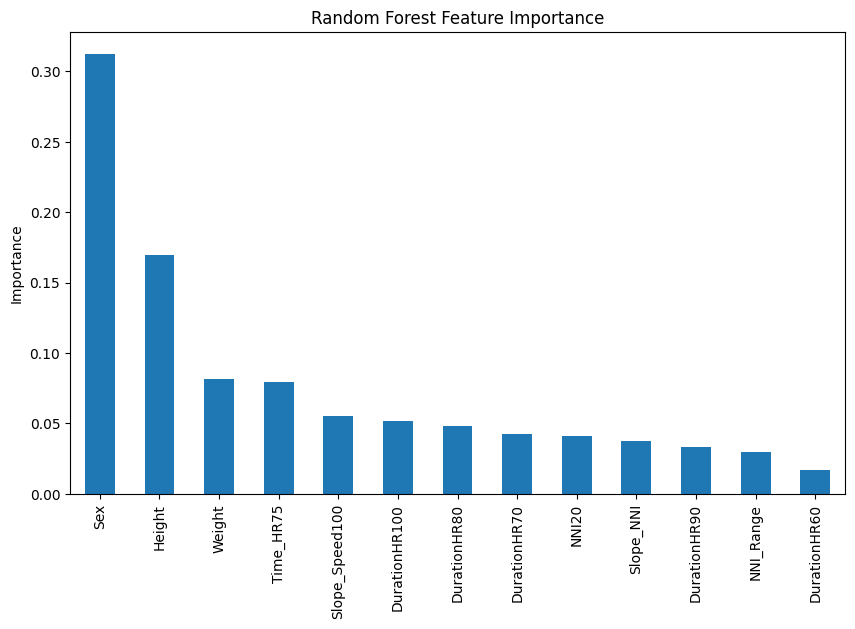

Feature importance scores:
Sex               0.312227
Height            0.169846
Weight            0.081663
Time_HR75         0.079403
Slope_Speed100    0.055444
DurationHR100     0.051726
DurationHR80      0.048008
DurationHR70      0.042168
NNI20             0.041304
Slope_NNI         0.037844
DurationHR90      0.033417
NNI_Range         0.029904
DurationHR60      0.017047
dtype: float64


In [116]:
# Random Forest Feature Importance
feature_importance_exercise = random_forest_feature_importance(final_data_exercise, 'VO2max')
print("Feature importance scores:")
print(feature_importance_exercise)

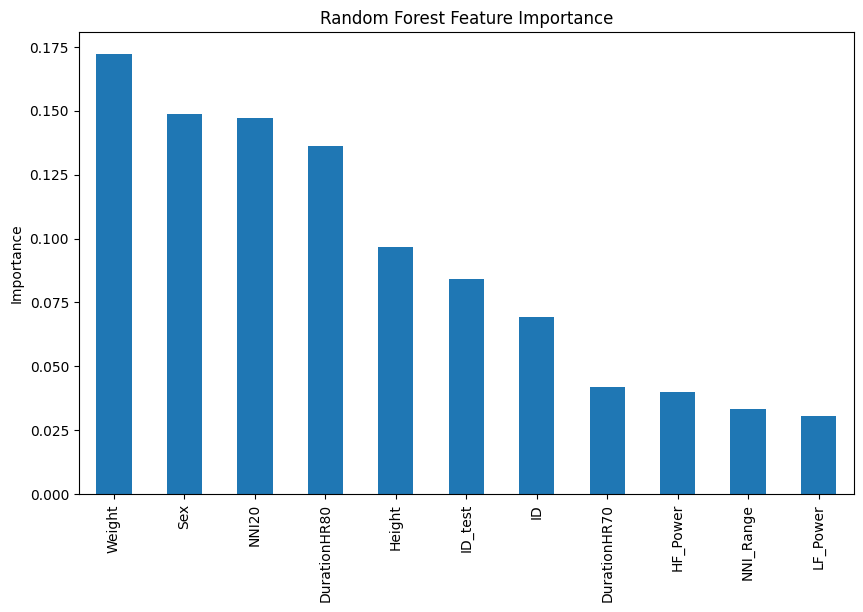

Feature importance scores:
Weight          0.172147
Sex             0.148836
NNI20           0.147076
DurationHR80    0.136107
Height          0.096722
ID_test         0.084300
ID              0.069398
DurationHR70    0.041780
HF_Power        0.039803
NNI_Range       0.033376
LF_Power        0.030454
dtype: float64


In [118]:
# Random Forest Feature Importance
feature_importance_recovery = random_forest_feature_importance(final_data_recovery, 'VO2max')
print("Feature importance scores:")
print(feature_importance_recovery)

In [120]:
# Recursive Feature Elimination (RFE)
selected_features_exercise_rec = rfe_feature_selection(final_data_exercise, 'VO2max', num_features=5)
print(f"Selected Features using RFE (top 5): {selected_features_exercise_rec}")

Selected Features using RFE (top 5): Index(['Height', 'Sex', 'Weight', 'Time_HR75', 'Slope_Speed100'], dtype='object')


In [121]:
# Recursive Feature Elimination (RFE)
selected_features_recovery_rec = rfe_feature_selection(final_data_recovery, 'VO2max', num_features=5)
print(f"Selected Features using RFE (top 5): {selected_features_recovery_rec}")

Selected Features using RFE (top 5): Index(['Weight', 'Sex', 'NNI20', 'DurationHR80', 'ID_test'], dtype='object')


### Greedy-Forward-Backward-Selection

In [27]:
# greedy forward backward feature selection

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

def forward_backward_feature_selection(data, target_column, model, direction='both', scoring='neg_mean_squared_error', cv=5):
    """
    Perform greedy feature selection (forward, backward, or both) to find the optimal feature set.

    Parameters:
        data (pd.DataFrame): The dataset containing features and target.
        target_column (str): The name of the target column.
        model (object): A Scikit-learn compatible ML model for evaluation.
        direction (str): The strategy for feature selection ('forward', 'backward', or 'both').
        scoring (str): Scoring metric for model evaluation during feature selection.
        cv (int): Number of cross-validation folds.

    Returns:
        list: List of the final selected features.
        float: Performance (MSE) of the final model on the test set.
    """
    # Step 1: Separate features and target
    X = data.drop(columns=[target_column])  # Features
    y = data[target_column]  # Target variable

    # Step 2: Split dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    # Step 3: Initialize forward feature selection
    if direction in ['forward', 'both']:
        forward_selector = SequentialFeatureSelector(
            model,
            n_features_to_select="auto",  # Automatically determines the best number of features
            direction="forward",  # Forward selection
            scoring=scoring,  # Evaluation metric
            cv=cv,  # Cross-validation folds
            n_jobs=-1  # Use all available processors
        )
        forward_selector.fit(X_train, y_train)
        forward_features = X_train.columns[forward_selector.get_support()].tolist()
    else:
        forward_features = X.columns.tolist()  # Skip forward step if not needed

    # Step 4: Update training and testing data to include only forward-selected features
    X_train_forward = X_train[forward_features]
    X_test_forward = X_test[forward_features]
    
    pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())])

    # Extract model from pipeline
    model = pipeline.named_steps['model']

    # Step 5: Initialize backward feature elimination
    if direction in ['backward', 'both']:
        backward_selector = SequentialFeatureSelector(
            model,
            n_features_to_select="auto",  # Automatically determines the best number of features
            direction="backward",  # Backward elimination
            scoring=scoring,  # Evaluation metric
            cv=cv,  # Cross-validation folds
            n_jobs=-1  # Use all available processors
        )
        backward_selector.fit(X_train_forward, y_train)
        final_features = X_train_forward.columns[backward_selector.get_support()].tolist()
    else:
        final_features = forward_features  # Skip backward step if not needed

    # Step 6: Train the final model using the selected features
    model.fit(X_train[final_features], y_train)
    y_pred = model.predict(X_test[final_features])

    # Step 7: Evaluate model performance
    performance = mean_squared_error(y_test, y_pred)
    #print(y_test)
    #print(y_pred)
    return final_features, performance



# Model Testing

### Forward Backward Features

In [28]:
# Multiple Linear Regression
MLR_model = LinearRegression()

final_features_MLR, performance_MLR = forward_backward_feature_selection(
    data=final_data_exercise,
    target_column='VO2max',
    model=MLR_model,
    direction='both',  # Perform both forward and backward selection
    scoring='neg_mean_squared_error',  # Use MSE as the scoring metric
    cv=5  # 5-fold cross-validation
)

print("MLR Selected Features:", final_features_MLR)
print("MLR Performance (MSE):", performance_MLR)

MLR Selected Features: ['Height', 'Sex', 'Time_HR75']
MLR Performance (MSE): 0.45051752809163415


In [29]:
# Random Forest Regressor
RF_model = RandomForestRegressor(n_estimators=100, random_state=42)
final_features_RF, performance_RF = forward_backward_feature_selection(
    data=final_data_exercise,
    target_column='VO2max',
    model=RF_model,
    direction='both',  # Perform both forward and backward selection
    scoring='neg_mean_squared_error',  # Use MSE as the scoring metric
    cv=5  # 5-fold cross-validation
)

print("RF Selected Features:", final_features_RF)
print("RF Performance (MSE):", performance_RF)

RF Selected Features: ['Height', 'Sex', 'Time_HR75']
RF Performance (MSE): 0.45051752809163415


In [31]:
from sklearn.svm import SVR
# # Greedy FS with Support Vector Regression
SVR_model = SVR(kernel='linear')  
final_features, performance = forward_backward_feature_selection(
    data=final_data_exercise,
    target_column='VO2max',
    model=SVR_model,
    direction='both',  # Forward and backward
    scoring='neg_mean_squared_error',
    cv=2
)

print("SVR Selected Features:", final_features)
print("SVR Performance (MSE):", performance)

SVR Selected Features: ['Height', 'Sex', 'Time_HR75']
SVR Performance (MSE): 0.45051752809163415


# Model Fitting

In [127]:
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor

In [131]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

def greedy_forward_backward_selection(data, target_column, model, direction='forward', scoring='neg_mean_squared_error', cv=5, num_features=5):
    """
    Funktion zur Feature Selection mit Vorwärts- und Rückwärts-Elimination
    """
    # Features und Zielspalte trennen
    X = data.drop(columns=[target_column])
    y = data[target_column]
    
    # Eine Pipeline erstellen, um Skalierung und Modell zu kombinieren
    pipeline = Pipeline([
        ('model', model)
    ])
    
    # Vorwärts- oder Rückwärts-Elimination durchführen
    if direction in ['forward', 'both']:
        forward_selector = SequentialFeatureSelector(
            pipeline,
            n_features_to_select=num_features,
            direction='forward',
            scoring=scoring,
            cv=cv,
            n_jobs=-1
        )
        forward_selector.fit(X, y)
        forward_features = X.columns[forward_selector.get_support()].tolist()
    else:
        forward_features = []
    
    if direction in ['backward', 'both']:
        backward_selector = SequentialFeatureSelector(
            pipeline,
            n_features_to_select=num_features,
            direction='backward',
            scoring=scoring,
            cv=cv,
            n_jobs=-1
        )
        backward_selector.fit(X, y)
        backward_features = X.columns[backward_selector.get_support()].tolist()
    else:
        backward_features = []
    
    # Zusammenführen der Ergebnisse von Vorwärts- und Rückwärts-Elimination
    selected_features = list(set(forward_features + backward_features))
    
    return selected_features


In [132]:
# Funktion zur Modellbewertung und Hyperparameter-Tuning mit GridSearch
def model_evaluation_with_grid_search(dataframe, target_column, feature_selection_function, num_features=5, cv=5):
    # Feature Selection durchführen
    selected_features = feature_selection_function(dataframe, target_column, num_features)
    
    # Features und Zielspalte vorbereiten
    X_selected = dataframe[selected_features]
    y_selected = dataframe[target_column]
    
    # Modelle zur Vorhersage von VO2max
    models = {
        'Random Forest': RandomForestRegressor(random_state=42),
        'XGBoost': XGBRegressor(random_state=42),
        'SVR': SVR(),
        'Linear Regression': LinearRegression()
    }
    
    # Hyperparameter-Tuning für alle Modelle, die es unterstützen
    param_grids = {
        'Random Forest': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10]
        },
        'XGBoost': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 6, 10]
        },
        'SVR': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        },
        'Linear Regression': {}  # Linear Regression hat keine Hyperparameter, die wir optimieren müssen
    }
    
    # Funktion zur Auswertung von Modellen mit Cross-Validation
    def evaluate_model(model, param_grid, X, y, cv=5):
        # GridSearch mit Cross-Validation
        if param_grid:
            grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='neg_mean_squared_error')
            grid_search.fit(X, y)
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
            best_score = grid_search.best_score_
            print(f"Best Hyperparameters for {model.__class__.__name__}: {best_params}")
            print(f"Best Cross-validation MSE for {model.__class__.__name__}: {-best_score}")
        else:
            # Kein GridSearch für Modelle ohne Hyperparameteroptimierung
            best_model = model
            best_model.fit(X, y)
            best_params = None
            best_score = None
        
        return best_model, best_params, best_score
    
    # Modelle evaluieren
    for model_name, model in models.items():
        print(f"Evaluating {model_name}...")
        
        # Hyperparameter-Tuning durchführen und beste Parameter finden
        best_model, best_params, best_score = evaluate_model(model, param_grids.get(model_name), X_selected, y_selected, cv)
        
        # Endgültige Vorhersage und Evaluierung des besten Modells
        y_pred = best_model.predict(X_selected)
        mse = mean_squared_error(y_selected, y_pred)
        
        print(f"Final MSE for {model_name}: {mse}\n")


In [126]:
# recursive feature selection
model_evaluation_with_grid_search(final_data_exercise, target_column='VO2max', feature_selection_function=rfe_feature_selection, num_features=5)

Evaluating Random Forest...
Best Hyperparameters for RandomForestRegressor: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Best Cross-validation MSE for RandomForestRegressor: 0.5017801022325931
Final MSE for Random Forest: 0.21540849498712364

Evaluating XGBoost...
Best Hyperparameters for XGBRegressor: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best Cross-validation MSE for XGBRegressor: 0.47875281768729766
Final MSE for XGBoost: 0.3530357277066023

Evaluating SVR...
Best Hyperparameters for SVR: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best Cross-validation MSE for SVR: 0.48059524308924634
Final MSE for SVR: 0.45903129768919315

Evaluating Linear Regression...
Final MSE for Linear Regression: 0.4582326066294977



In [133]:
# Beispiel für die Verwendung der Funktion
model_evaluation_with_grid_search(final_data_exercise, target_column='VO2max', 
                                  feature_selection_function=greedy_forward_backward_selection, 
                                  num_features=5, cv=5)


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/sklearn/pipeline.py", line 469, in fit
    Xt = self._fit(X, y, routed_params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/sklearn/pipeline.py", line 386, in _fit
    self._validate_steps()
  File "/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/sklearn/pipeline.py", line 269, in _validate_steps
    raise TypeError(
TypeError: Last step of Pipeline should implement fit or be the string 'passthrough'. '5' (type <class 'int'>) doesn't


## Data Generation with tsfel

In [39]:
import tsfel

In [62]:
# prepare dataesets for tsfel use

exercise_data['time'] = pd.to_numeric(exercise_data['time'])
exercise_data['VO2'] = pd.to_numeric(exercise_data['VO2'])
exercise_data['ID_test'] = exercise_data['ID_test'].astype(str)

recovery_data['time'] = pd.to_numeric(recovery_data['time'])
recovery_data['VO2'] = pd.to_numeric(recovery_data['VO2'])
recovery_data['ID_test'] = recovery_data['ID_test'].astype(str)

exercise_data_tsfel = exercise_data.sort_values(by=['ID_test', 'time']).reset_index(drop=True)
recovery_data_tsfel = recovery_data.sort_values(by=['ID_test', 'time']).reset_index(drop=True)

In [ ]:
# Function to segment time series into dynamic time windows
def segment_time_series_dynamic(group, window_size):
    """
    Segments a time series into dynamic time windows based on irregular time intervals.

    Parameters:
        group (DataFrame): A subset of the dataset grouped by ID or another identifier.
        window_size (int): The size of the time window in seconds.

    Returns:
        DataFrame: A DataFrame containing aggregated features and metadata for each time window.
    """
    results = []
    times = group['time'].values  # Extract time values
    vo2_values = group['VO2'].values  # Extract VO2 values

    start_idx = 0
    while start_idx < len(times):
        # Dynamically calculate the end time for the current window
        end_time = times[start_idx] + window_size
        end_idx = np.searchsorted(times, end_time)

        # Extract the data within the current time window
        window_data = group.iloc[start_idx:end_idx]

        # Skip window if it contains too few data points (minimum 3 for slope calculation)
        if len(window_data) < 3:
            start_idx = end_idx
            continue

        # Remove NaN and invalid values
        window_data = window_data.dropna()
        if window_data.empty:
            start_idx = end_idx
            continue

        # Calculate VO2_max for the window
        vo2_max = vo2_values[start_idx:end_idx].max()

        # TSFEL requires time series data as a NumPy array
        ts_data = window_data[['Speed', 'HR', 'VCO2', 'RR', 'VE', 'HR_diff']]

        # Calculate features for each column in the time series
        aggregated_features = {}
        for col in ts_data.columns:
            try:
                cfg_file = tsfel.get_features_by_domain("temporal")  # Temporal features
                tsfel_features = tsfel.time_series_features_extractor(cfg_file, ts_data[col].values, verbose=0)

                # Rename columns to include the metric name
                tsfel_features.columns = [f"{col}_{feature}" for feature in tsfel_features.columns]

                # Add features to the aggregated dictionary
                aggregated_features.update(tsfel_features.iloc[0].to_dict())
            except Exception as e:
                print(f"Error in column {col}: {e}")

        # Add additional metadata
        aggregated_features['ID_test'] = group['ID_test'].iloc[0]
        aggregated_features['time_start'] = times[start_idx]
        aggregated_features['time_end'] = times[end_idx - 1] if end_idx < len(times) else times[-1]
        aggregated_features['VO2_max'] = vo2_max

        # Append the results for the current window
        results.append(aggregated_features)

        # Move to the next time window
        start_idx = end_idx

    return pd.DataFrame(results)


In [ ]:
# Aggregate data by ID and time window
window_size = 30  # Time window in seconds
exercise_tsfel_results = pd.concat([
    segment_time_series_dynamic(group, window_size)
    for _, group in exercise_data_tsfel.groupby("ID_test")
])

window_size = 30  # Time window in seconds
recovery_tsfel_results = pd.concat([
    segment_time_series_dynamic(group, window_size)
    for _, group in recovery_data_tsfel.groupby("ID_test")
])

In [68]:
# merge to subject data

exercise_tsfel = pd.merge(subject_data, exercise_tsfel_results, on='ID_test', how='inner')
recovery_tsfel = pd.merge(subject_data, recovery_tsfel_results, on='ID_test', how='inner')

In [69]:
# normalize data

normalized_exercise_tsfel = normalize_features(exercise_tsfel)
normalized_recovery_tsfel = normalize_features(recovery_tsfel)

In [70]:
# feature selection for exercise

final_exercise_data_tsfel = feature_selection_pipeline(
    normalized_exercise_tsfel, target_column='VO2_max', 
    corr_threshold=0.7, 
    nan_threshold=0.5, 
    mi_threshold=0.0, 
    spearman_threshold=0.1,
    correlation_fs = False, nan_fs = True, mi_fs = True, spearman_fs = True
)

Features to remove with more than 50.0% NaN values: Index([], dtype='object')
Selected Features (MI > 0.0): ['VCO2_0_Area under the curve', 'Speed_0_Area under the curve', 'time_end', 'time_start', 'VE_0_Area under the curve', 'Speed_0_Centroid', 'HR_0_Centroid', 'VCO2_0_Centroid', 'Speed_0_Signal distance', 'HR_0_Area under the curve', 'Height', 'Weight', 'Speed_0_Sum absolute diff', 'Speed_0_Slope', 'Speed_0_Mean absolute diff', 'Speed_0_Mean diff', 'HR_0_Mean diff', 'HR_0_Slope', 'VE_0_Mean absolute diff', 'ID', 'Sex', 'RR_0_Area under the curve', 'VCO2_0_Sum absolute diff', 'VE_0_Sum absolute diff', 'HR_0_Mean absolute diff', 'VCO2_0_Signal distance', 'RR_0_Centroid', 'HR_0_Sum absolute diff', 'VE_0_Signal distance', 'RR_0_Median absolute diff', 'VCO2_0_Mean diff', 'VE_0_Mean diff', 'VCO2_0_Mean absolute diff', 'RR_0_Mean absolute diff', 'VE_0_Slope', 'Speed_0_Median absolute diff', 'HR_0_Signal distance', 'Speed_0_Median diff', 'VE_0_Centroid', 'VCO2_0_Slope', 'RR_0_Sum absolute d

/var/folders/bd/3yf697f17xx34gzbkjr3wz9r0000gn/T/ipykernel_49280/3246266667.py:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, _ = spearmanr(dataframe[column], dataframe[target_column])


In [71]:
# feature selection for recovery

final_recovery_data_tsfel = feature_selection_pipeline(
    normalized_recovery_tsfel, target_column='VO2_max', 
    corr_threshold=0.7, 
    nan_threshold=0.5, 
    mi_threshold=0.0, 
    spearman_threshold=0.1,
    correlation_fs = False, nan_fs = True, mi_fs = True, spearman_fs = True
)

Features to remove with more than 50.0% NaN values: Index([], dtype='object')
Selected Features (MI > 0.0): ['VCO2_0_Area under the curve', 'VE_0_Area under the curve', 'HR_0_Area under the curve', 'VCO2_0_Signal distance', 'VCO2_0_Sum absolute diff', 'RR_0_Area under the curve', 'Speed_0_Area under the curve', 'HR_0_Centroid', 'Speed_0_Centroid', 'HR_0_Signal distance', 'VCO2_0_Centroid', 'VE_0_Sum absolute diff', 'Speed_0_Signal distance', 'RR_0_Centroid', 'VE_0_Signal distance', 'VE_0_Centroid', 'HR_0_Sum absolute diff', 'HR_diff_0_Area under the curve', 'HR_diff_0_Signal distance', 'RR_0_Signal distance', 'HR_diff_0_Centroid', 'HR_0_Slope', 'HR_0_Mean diff', 'RR_0_Mean diff', 'Weight', 'VCO2_0_Median diff', 'VE_0_Mean absolute diff', 'HR_diff_0_Sum absolute diff', 'VCO2_0_Mean absolute diff', 'VCO2_0_Slope', 'HR_diff_0_Positive turning points', 'HR_0_Median diff', 'VCO2_0_Median absolute diff', 'RR_0_Sum absolute diff', 'VE_0_Mean diff', 'HR_diff_0_Slope', 'VE_0_Positive turning po

/var/folders/bd/3yf697f17xx34gzbkjr3wz9r0000gn/T/ipykernel_49280/3246266667.py:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, _ = spearmanr(dataframe[column], dataframe[target_column])


### Feature selection tree based and recursive

In [72]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
import seaborn as sns

In [73]:
# Random Forest Feature Importance (Tree-Based)
def random_forest_feature_importance(data, target_column):
    # Separate features and target
    X = data.drop(columns=[target_column])
    y = data[target_column]
    
    # Fit RandomForest model
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    # Get feature importance scores
    feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
    
    # Plot Feature Importance
    feature_importance.plot(kind='bar', figsize=(10, 6))
    plt.title('Random Forest Feature Importance')
    plt.ylabel('Importance')
    plt.show()
    
    return feature_importance

In [74]:
# Recursive Feature Elimination (RFE)
def rfe_feature_selection(data, target_column, num_features=5):
    # Separate features and target
    X = data.drop(columns=[target_column])
    y = data[target_column]
    
    # Initialize the model (Random Forest Regressor)
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    
    # Initialize RFE
    selector = RFE(rf, n_features_to_select=num_features)
    selector = selector.fit(X, y)
    
    # Get selected features
    selected_features = X.columns[selector.support_]
    
    return selected_features

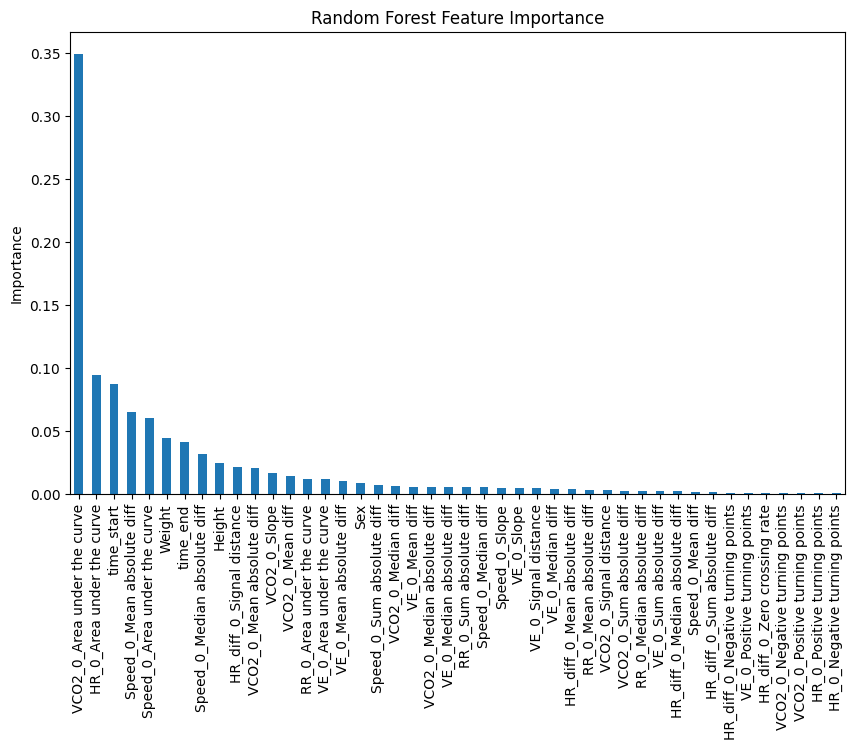

Feature importance scores:
VCO2_0_Area under the curve          0.349495
HR_0_Area under the curve            0.094556
time_start                           0.087222
Speed_0_Mean absolute diff           0.065412
Speed_0_Area under the curve         0.060343
Weight                               0.044162
time_end                             0.040857
Speed_0_Median absolute diff         0.031885
Height                               0.024733
HR_diff_0_Signal distance            0.021304
VCO2_0_Mean absolute diff            0.020286
VCO2_0_Slope                         0.016802
VCO2_0_Mean diff                     0.014488
RR_0_Area under the curve            0.011976
VE_0_Area under the curve            0.011666
VE_0_Mean absolute diff              0.009968
Sex                                  0.008713
Speed_0_Sum absolute diff            0.007430
VCO2_0_Median diff                   0.006475
VE_0_Mean diff                       0.005757
VCO2_0_Median absolute diff          0.005433
VE_0_Me

In [76]:
# Random Forest Feature Importance
feature_importance_exercise = random_forest_feature_importance(final_exercise_data_tsfel, 'VO2_max')
print("Feature importance scores:")
print(feature_importance_exercise)

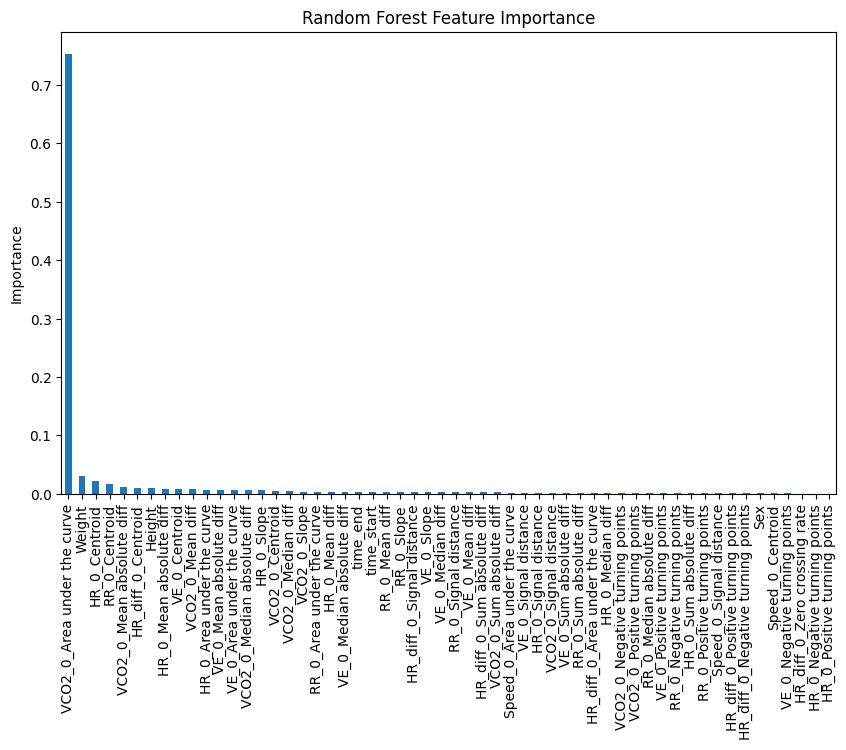

Feature importance scores:
VCO2_0_Area under the curve          0.753330
Weight                               0.030102
HR_0_Centroid                        0.021567
RR_0_Centroid                        0.017531
VCO2_0_Mean absolute diff            0.012175
HR_diff_0_Centroid                   0.010304
Height                               0.009535
HR_0_Mean absolute diff              0.009198
VE_0_Centroid                        0.008795
VCO2_0_Mean diff                     0.007793
HR_0_Area under the curve            0.007323
VE_0_Mean absolute diff              0.007174
VE_0_Area under the curve            0.006554
VCO2_0_Median absolute diff          0.006208
HR_0_Slope                           0.006000
VCO2_0_Centroid                      0.005398
VCO2_0_Median diff                   0.005080
VCO2_0_Slope                         0.003943
RR_0_Area under the curve            0.003837
HR_0_Mean diff                       0.003746
VE_0_Median absolute diff            0.003338
time_en

In [77]:
# Random Forest Feature Importance
feature_importance_recovery = random_forest_feature_importance(final_recovery_data_tsfel, 'VO2_max')
print("Feature importance scores:")
print(feature_importance_recovery)

In [78]:
# Recursive Feature Elimination (RFE)
selected_features_rfe_exercise = rfe_feature_selection(final_exercise_data_tsfel, 'VO2_max', num_features=8)
print(f"Selected Features using RFE (top 8): {selected_features_rfe_exercise}")

Selected Features using RFE (top 8): Index(['VCO2_0_Area under the curve', 'Speed_0_Area under the curve',
       'time_end', 'time_start', 'HR_0_Area under the curve', 'Weight',
       'Speed_0_Mean absolute diff', 'VCO2_0_Slope'],
      dtype='object')


In [ ]:
# Recursive Feature Elimination (RFE)
selected_features_rfe_recovery = rfe_feature_selection(final_recovery_data_tsfel, 'VO2_max', num_features=8)
print(f"Selected Features using RFE (top 8): {selected_features_rfe_recovery}")